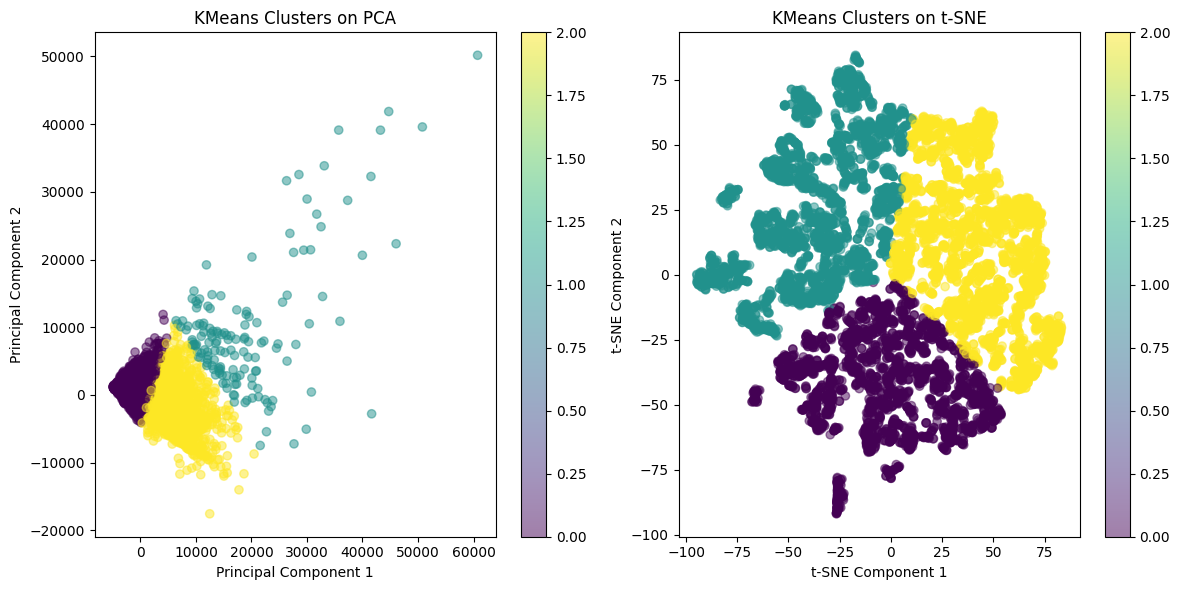

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Charger le dataset
path = "CC GENERAL.csv"
df = pd.read_csv(path)

# Gérer les valeurs manquantes pour les colonnes numériques
numeric_imputer = SimpleImputer(strategy='mean')
df_numeric_filled = pd.DataFrame(numeric_imputer.fit_transform(df.select_dtypes
                                                               (include=['number'])), 
                                 columns=df.select_dtypes(include=['number']).columns)

# Gérer les valeurs manquantes pour les colonnes non numériques
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_categorical_filled = pd.DataFrame(categorical_imputer.fit_transform(df.select_dtypes
                                                                       (exclude=['number'])), 
                                     columns=df.select_dtypes(exclude=['number']).columns)

# Concaténer les deux DataFrames
df_filled = pd.concat([df_numeric_filled, df_categorical_filled], axis=1)

# Séparer les colonnes numériques et non numériques
numeric_columns = df_filled.select_dtypes(include=['number']).columns
categorical_columns = df_filled.select_dtypes(exclude=['number']).columns

# Appliquer PCA aux colonnes numériques
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_filled[numeric_columns])

# Appliquer t-SNE aux colonnes numériques
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_filled[numeric_columns])

# Appliquer KMeans sur les features PCA
K_pca = 3  
kmeans_pca = KMeans(n_clusters=K_pca, n_init=10, random_state=42)
df['Cluster_KMeans_PCA'] = kmeans_pca.fit_predict(pca_result)

# Appliquer KMeans sur les features t-SNE
K_tsne = 3  # 
kmeans_tsne = KMeans(n_clusters=K_tsne, n_init=10, random_state=42)
df['Cluster_KMeans_TSNE'] = kmeans_tsne.fit_predict(tsne_result)

# Plotting KMeans clusters on PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['Cluster_KMeans_PCA'], cmap='viridis', alpha=0.5)
plt.title('KMeans Clusters on PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()

# Plotting KMeans clusters on t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['Cluster_KMeans_TSNE'], cmap='viridis', alpha=0.5)
plt.title('KMeans Clusters on t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()

plt.tight_layout()
plt.show()


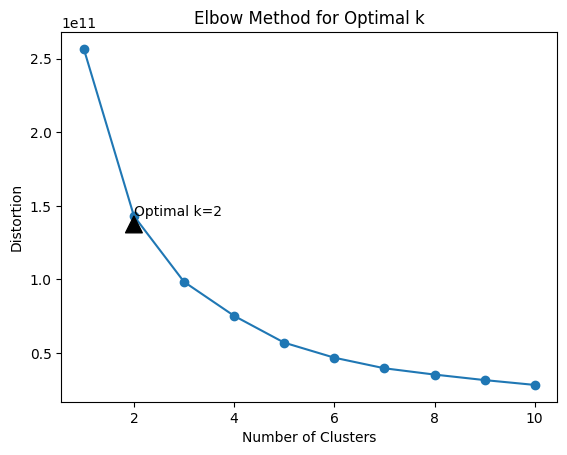

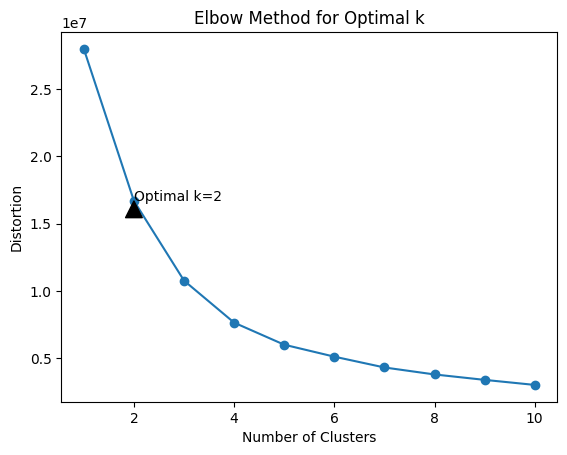

Optimal k for PCA: 2
Optimal k for t-SNE: 2


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_elbow_curve(distortions, max_k, title, x_label, y_label):
    # Tracer la courbe d'Elbow
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def find_optimal_k(data, max_k=10, plot=True):
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    # Trouver le point d'Elbow (minimum de la dérivée seconde)
    second_derivative = np.diff(np.diff(distortions))
    elbow_point = np.argmax(second_derivative) + 2  # +2 car np.diff réduit la taille de l'array

    if plot:
        # Ajouter la valeur de k exacte au-dessus du graphe
        plt.annotate(f'Optimal k={elbow_point}', xy=(elbow_point, distortions[elbow_point - 1]),
                     xytext=(elbow_point, distortions[elbow_point - 1] + 1000),
                     arrowprops=dict(facecolor='black', shrink=0.05))

        plot_elbow_curve(distortions, max_k, 'Elbow Method for Optimal k', 'Number of Clusters', 'Distortion')

    return elbow_point

# Appliquer la méthode d'Elbow pour PCA
optimal_k_pca = find_optimal_k(pca_result)

# Appliquer la méthode d'Elbow pour t-SNE
optimal_k_tsne = find_optimal_k(tsne_result)

# les valeurs optimales de k pour chaque méthode si nécessaire
print(f'Optimal k for PCA: {optimal_k_pca}')
print(f'Optimal k for t-SNE: {optimal_k_tsne}')


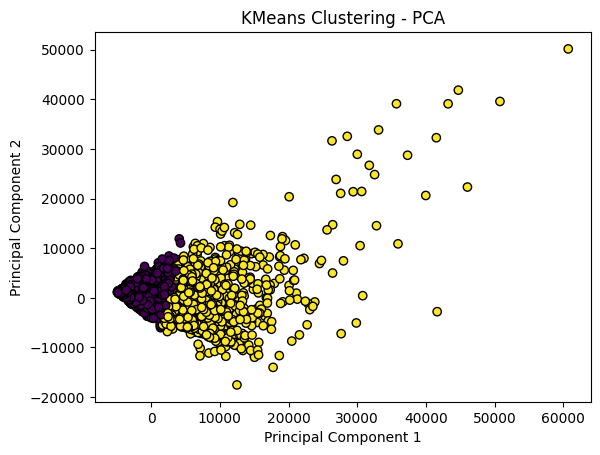

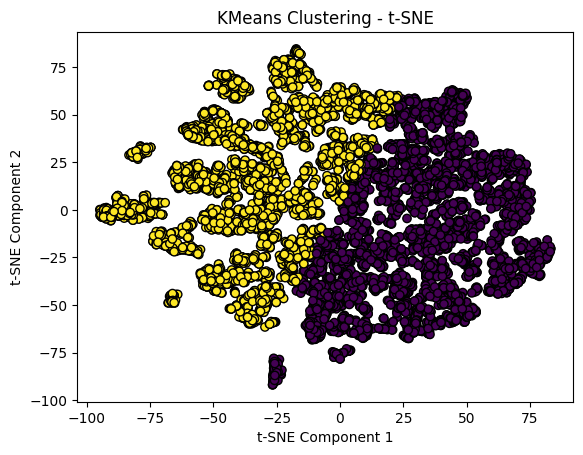

In [21]:
# Appliquer la méthode d'Elbow pour PCA
optimal_k_pca = find_optimal_k(pca_result, plot=False)  # plot=False pour éviter de tracer la courbe ici

# Appliquer KMeans basé sur PCA avec le nombre optimal de clusters
kmeans_pca = KMeans(n_clusters=optimal_k_pca, n_init=10, random_state=42)
df['cluster_pca'] = kmeans_pca.fit_predict(pca_result)

# Visualiser les clusters obtenus avec KMeans basé sur PCA
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['cluster_pca'], cmap='viridis', edgecolor='k')
plt.title('KMeans Clustering - PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Appliquer la méthode d'Elbow pour t-SNE
optimal_k_tsne = find_optimal_k(tsne_result, plot=False)

# Appliquer KMeans basé sur t-SNE avec le nombre optimal de clusters
kmeans_tsne = KMeans(n_clusters=optimal_k_tsne, n_init=10, random_state=42)
df['cluster_tsne'] = kmeans_tsne.fit_predict(tsne_result)

# Visualiser les clusters obtenus avec KMeans basé sur t-SNE
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['cluster_tsne'], cmap='viridis', edgecolor='k')
plt.title('KMeans Clustering - t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [25]:
import skfuzzy as fuzz
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from minisom import MiniSom
import numpy as np
import importlib


features = df.drop(columns=['column_to_drop_if_needed'])

# Question 5: Refaire la même chose en utilisant l'algorithme fuzzy cmeans
def fuzzy_cmeans_clustering(data, n_clusters, m=2, error=0.005, max_iter=1000):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n_clusters, m, error, max_iter)
    return np.argmax(u, axis=0)

# Apply fuzzy cmeans
optimal_k_pca = 3  # Replace with the appropriate value
df['cluster_fuzzy'] = fuzzy_cmeans_clustering(features, n_clusters=optimal_k_pca)

# Question 5: Refaire la même chose en utilisant l'algorithme DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['cluster_dbscan'] = dbscan.fit_predict(features)

# Question 5: Refaire la même chose en utilisant l'algorithme EM (Gaussian Mixture Model)
gmm = GaussianMixture(n_components=optimal_k_pca, random_state=42)
df['cluster_em'] = gmm.fit_predict(features)

# Question 5: Refaire la même chose en utilisant l'algorithme SOM (Self-Organizing Map)
som = MiniSom(5, 5, features.shape[1], sigma=0.5, learning_rate=0.5)
som.train(features, 100)
df['cluster_som'] = np.argmin(som.distance_map(features), axis=1)

# Question 5: Refaire la même chose en utilisant l'algorithme Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k_pca)
df['cluster_hierarchical'] = hierarchical.fit_predict(features)


ModuleNotFoundError: No module named 'imp'